*<centre> Machine Learning for Social Data Science <centre/>*

Problem Set 1

(1,500 words)

In [11]:
#Import dataset
import pandas as pd

df = pd.read_stata("../../../Statistical Modelling/Assessments/BES2024_W30_v30.0.dta")

In [12]:
#Subset to keep key variables
BES = df[["id", "generalElectionVote", "age", "gender", "p_ethnicity", "p_religion", 
          "p_sexuality", "p_disability", "p_edlevel", "subjClass", "gor"]].copy()

#Rename column names
BES = BES.rename(columns = {"generalElectionVote": "General_Election_Vote", "age": "Age", "gender": "Gender", "p_ethnicity": "Ethnicity",
"p_religion": "Religion", "p_sexuality": "Sexuality", "p_disability": "Disability", "p_edlevel": "Education_Level", "subjClass": "Subjective_Class",
"gor": "Region"})

In [13]:
#Preprocess Target Variable
BES["Labour_vote"] = (BES["General_Election_Vote"] == 'Labour').astype(int)

#Preprocess features
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import numpy as np

categorical_variables = ['Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 'Education_Level', 'Subjective_Class', 'Region']

for col in categorical_variables:
    BES[col] = BES[col].astype('category')

In [14]:
#Summary statistics
BES.describe(include = 'all')

,id,General_Election_Vote,Age,Gender,Ethnicity,Religion,Sexuality,Disability,Education_Level,Subjective_Class,Region,Labour_vote
count,30342.000000,29800,30342.0,30342,30342,30104,30227,29837,26273,30342,30342,30342.000000
unique,NaN,10,79.0,2,16,19,5,3,6,5,12,NaN
top,NaN,Brexit Party/Reform UK,69.0,Female,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,Undergraduate,"Yes, working class",South East,NaN
freq,NaN,7226,749.0,16751,26579,16071,26250,20029,9200,12131,4410,NaN
mean,67896.568453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.177675
std,39248.025493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382245
min,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,33155.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,70868.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,104337.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [15]:
BES.sample(25)

,id,General_Election_Vote,Age,Gender,Ethnicity,Religion,Sexuality,Disability,Education_Level,Subjective_Class,Region,Labour_vote
26244,118546,I would/did not vote,39,Female,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,A-level,No,South East,0
21301,96894,Green Party,48,Male,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,Undergraduate,No,East,0
20947,95297,Don't know,53,Male,White British,Yes - Judaism,Heterosexual,No,Undergraduate,"Yes, middle class",Yorkshire and the Humber,0
8943,41922,Brexit Party/Reform UK,59,Male,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,A-level,No,East,0
22603,103482,Brexit Party/Reform UK,45,Female,White British,"No, I do not regard myself as belonging to any...",Heterosexual,"Yes, limited a little",NaN,"Yes, working class",East,0
5484,20615,Conservative,54,Male,White British,Prefer not to say,Prefer not to say,No,GCSE,No,South West,0
14506,67282,Don't know,43,Female,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,Undergraduate,No,South West,0
1150,4359,Conservative,55,Male,White British,"No, I do not regard myself as belonging to any...",Heterosexual,"Yes, limited a lot",Undergraduate,"Yes, working class",Wales,0
7729,34599,Brexit Party/Reform UK,69,Male,White British,Yes - Church of England/Anglican/Episcopal,Heterosexual,"Yes, limited a little",No qualifications,"Yes, working class",East,0
23670,108266,Don't know,22,Female,Black African,"No, I do not regard myself as belonging to any...",Heterosexual,No,Undergraduate,"Yes, middle class",West Midlands,0


Boosted Decision Tree

In [16]:
#Choose feature and target variables
features = ['Age', 'Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 'Education_Level', 'Subjective_Class', 'Region'] 
target = 'Labour_vote'

In [17]:
#Model 1 - Baseline

#Seperate into train and test sets
from sklearn.model_selection import train_test_split

BES_train, BES_test = train_test_split(BES, test_size = 0.2, random_state = 42)

#Create binary/logistic XGBoost model
import xgboost as xgb 

model1 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True)

#Train model
model1.fit(BES_train[features], BES_train[target])

#Predict on test set
pred1 = model1.predict(BES_test[features])


probability_model1 = model1.predict_proba(BES_test[features])[:,1]

#Calculate Metrics
from sklearn.metrics import precision_score, f1_score, recall_score, average_precision_score

metrics1 = {
    'Precision': precision_score(BES_test[target], pred1),
    'Recall': recall_score(BES_test[target], pred1),
    'F1': f1_score(BES_test[target], pred1),
    'PR-AUC': average_precision_score(BES_test[target], probability_model1)}

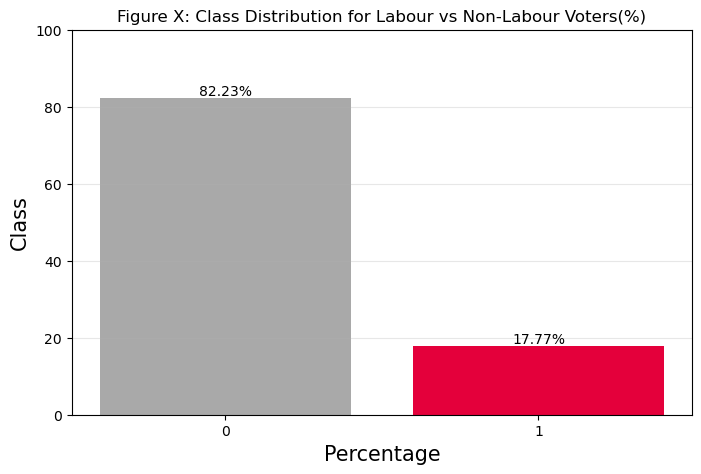

In [18]:
import matplotlib.pyplot as plt

class_percentage = BES['Labour_vote'].value_counts(normalize = True).sort_index() * 100

plt.figure(figsize = (8, 5))
plt.bar(class_percentage.index.astype(str), class_percentage.values, color = ['darkgrey', '#E4003B'])

plt.title('Figure X: Class Distribution for Labour vs Non-Labour Voters(%)')
plt.ylabel('Class', fontsize = 15)
plt.xlabel('Percentage', fontsize = 15)
plt.ylim(0, 100)
plt.grid(axis = 'y', alpha = 0.3)

for i, pct in enumerate(class_percentage.values):
    plt.text(i, pct, f'{pct:.2f}%', ha = 'center', va = 'bottom')

plt.show()

In [19]:
#Model 2 - Stratified

BES_train_stratified, BES_test_stratified = train_test_split(BES, test_size = 0.2, random_state = 42, stratify = BES[target])

#Checking classes are balanced
print(sum(BES_train_stratified[target])/len(BES_train_stratified[target]))
print(sum(BES_test_stratified[target])/len(BES_test_stratified[target]))

model2 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True)

model2.fit(BES_train_stratified[features], BES_train_stratified[target])

pred2 = model2.predict(BES_test_stratified[features])

probability_model2 = model2.predict_proba(BES_test[features])[:,1]

metrics2 = {
    'Precision': precision_score(BES_test_stratified[target], pred2),
    'Recall': recall_score(BES_test_stratified[target], pred2),
    'F1': f1_score(BES_test_stratified[target], pred2),
    'PR-AUC': average_precision_score(BES_test_stratified[target], probability_model2)}

0.17768714209203643
0.1776239907727797


In [20]:
#Model 3 - Scale Weight

#Create scale weight
positive = sum(BES_train_stratified[target] == 0) 
negative = sum(BES_train_stratified[target] == 1)

print(positive/negative)

model3 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           scale_pos_weight = positive/negative)

model3.fit(BES_train_stratified[features], BES_train_stratified[target])

pred3 = model3.predict(BES_test_stratified[features])

probability_model3 = model3.predict_proba(BES_test[features])[:,1]

metrics3 = {
    'Precision': precision_score(BES_test_stratified[target], pred3),
    'Recall': recall_score(BES_test_stratified[target], pred3),
    'F1': f1_score(BES_test_stratified[target], pred3),
    'PR-AUC': average_precision_score(BES_test_stratified[target], probability_model3)}

4.627869232552747


In [21]:
#Model 4 - Threshold

model4 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           scale_pos_weight = positive/negative)

model4.fit(BES_train_stratified[features], BES_train_stratified[target])

probability_model4 = model4.predict_proba(BES_test_stratified[features])[:,1]

threshold = 0.15
pred4 = (probability_model4 >= threshold).astype(int)

metrics4 = {
    'Precision': precision_score(BES_test_stratified[target], pred4),
    'Recall': recall_score(BES_test_stratified[target], pred4),
    'F1': f1_score(BES_test_stratified[target], pred4),
    'PR-AUC': average_precision_score(BES_test_stratified[target], probability_model4)}

In [22]:
#Model 5 - Bayesian Optimisation


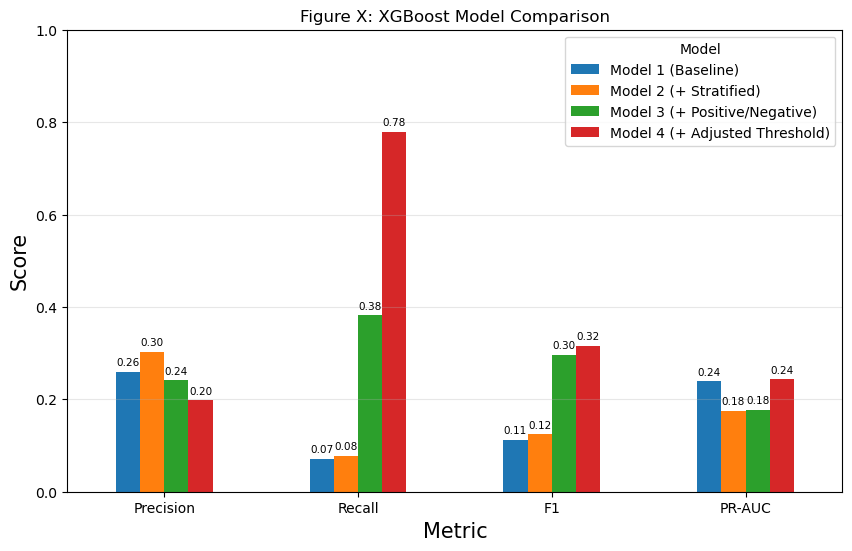

In [23]:
#Plot metrics

xgboost_model_scores = pd.DataFrame({
    'Model 1 (Baseline)': metrics1,
    'Model 2 (+ Stratified)': metrics2,
    'Model 3 (+ Positive/Negative)': metrics3,
    'Model 4 (+ Adjusted Threshold)': metrics4})

ax = xgboost_model_scores.plot(kind = 'bar', figsize = (10, 6))

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f', padding = 3, fontsize = 7.5)

plt.title('Figure X: XGBoost Model Comparison')
plt.ylabel('Score', fontsize = 15)
plt.xlabel('Metric', fontsize = 15)
plt.ylim(0, 1)
plt.xticks(rotation = 0)
plt.legend(title = 'Model')
plt.grid(axis = 'y', alpha = 0.3)
plt.show()

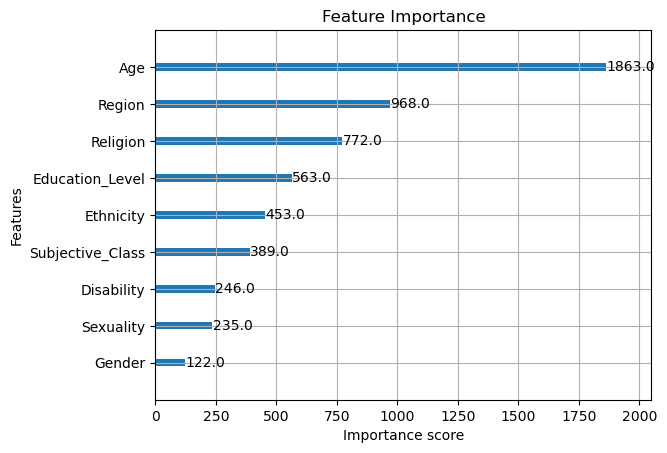

In [24]:
#Plot feature importance for model 5
import matplotlib.pyplot as plt

xgb.plot_importance(model4, importance_type = 'weight')
plt.title('Feature Importance')
plt.show()

Random Forest

In [25]:
#One-hot encode train and test sets
BES_train = BES_train.drop('General_Election_Vote', axis = 1)
BES_test = BES_test.drop('General_Election_Vote', axis = 1)

categorical_variables = ['Age', 'Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 
                         'Education_Level', 'Subjective_Class', 'Region']

BES_train = pd.get_dummies(BES_train, columns = categorical_variables) 
BES_test = pd.get_dummies(BES_test, columns = categorical_variables)

BES_test = BES_test.reindex(columns = BES_train.columns)
features = BES_train.columns.drop([target, 'id'])

In [26]:
#Model 1 - Baseline
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)

rf1.fit(BES_train[features], BES_train[target])

rf_pred1 = rf1.predict(BES_test[features])

rf1_probability = rf1.predict_proba(BES_test[features])[:,1]

rf_metrics1 = {
    'Precision': precision_score(BES_test[target], rf_pred1),
    'Recall': recall_score(BES_test[target], rf_pred1),
    'F1': f1_score(BES_test[target], rf_pred1),
    'PR-AUC': average_precision_score(BES_test[target], rf1_probability)}

In [27]:
#Model 2 - Stratified
BES_train_stratified = BES_train_stratified.drop('General_Election_Vote', axis = 1)
BES_test_stratified = BES_test_stratified.drop('General_Election_Vote', axis = 1)

categorical_variables = ['Age', 'Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 
                         'Education_Level', 'Subjective_Class', 'Region']

BES_train_stratified = pd.get_dummies(BES_train_stratified, columns = categorical_variables) 
BES_test_stratified = pd.get_dummies(BES_test_stratified, columns = categorical_variables)

BES_test_stratified = BES_test_stratified.reindex(columns = BES_train_stratified.columns)
features = BES_train_stratified.columns.drop([target, 'id'])

rf2 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)

rf2.fit(BES_train_stratified[features], BES_train_stratified[target])

rf_pred2 = rf2.predict(BES_test_stratified[features])

rf2_probability = rf2.predict_proba(BES_test_stratified[features])[:,1]

rf_metrics2 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred2),
    'Recall': recall_score(BES_test_stratified[target], rf_pred2),
    'F1': f1_score(BES_test_stratified[target], rf_pred2),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf2_probability)}

In [28]:
#Model 3 - Weights
rf3 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced', random_state = 42)

rf3.fit(BES_train_stratified[features], BES_train_stratified[target])

rf_pred3 = rf3.predict(BES_test_stratified[features])

rf3_probability = rf3.predict_proba(BES_test_stratified[features])[:,1]

rf_metrics3 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred3),
    'Recall': recall_score(BES_test_stratified[target], rf_pred3),
    'F1': f1_score(BES_test_stratified[target], rf_pred3),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf3_probability)}

In [29]:
#Model 4 - Adjusted Probaility Threshold
rf4 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced', random_state = 42)

rf4.fit(BES_train_stratified[features], BES_train_stratified[target])

rf4_probability = rf4.predict_proba(BES_test_stratified[features])[:, 1]

threshold = 0.15
rf_pred4 = (rf4_probability > threshold).astype(int)

rf_metrics4 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred4),
    'Recall': recall_score(BES_test_stratified[target], rf_pred4),
    'F1': f1_score(BES_test_stratified[target], rf_pred4),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf4_probability)}

#Hyperparameter Optimisation
from sklearn.model_selection import RandomizedSearchCV

parameter_distributions = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']}

rf = RandomForestClassifier(random_state = 42)

random_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = parameter_distributions,
    n_iter = 5,
    scoring = 'f1',
    cv = 5,
    return_train_score = True,
    n_jobs = -1,
    verbose = 2,
    random_state = 42)

random_search.fit(BES_train_stratified[features], BES_train_stratified[target])

threshold = 0.15
rf_prob = (rf_probability > threshold).astype(int)

print("Best hyperparameters:", random_search.best_params_)

In [31]:
#Model 5 - Best Hyperparamters
rf5 = RandomForestClassifier(n_estimators = 100, 
                             max_features = 'sqrt',
                             max_depth = 20,
                             min_samples_split = 5,
                             min_samples_leaf = 4,
                             criterion = 'entropy', 
                             class_weight = 'balanced', 
                             random_state = 42)

rf5.fit(BES_train_stratified[features], BES_train_stratified[target])

rf5_probability = rf5.predict_proba(BES_test_stratified[features])[:, 1]

threshold = 0.15
rf_pred5 = (rf5_probability > threshold).astype(int)

rf_metrics5 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred5),
    'Recall': recall_score(BES_test_stratified[target], rf_pred5),
    'F1': f1_score(BES_test_stratified[target], rf_pred5),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf5_probability)}

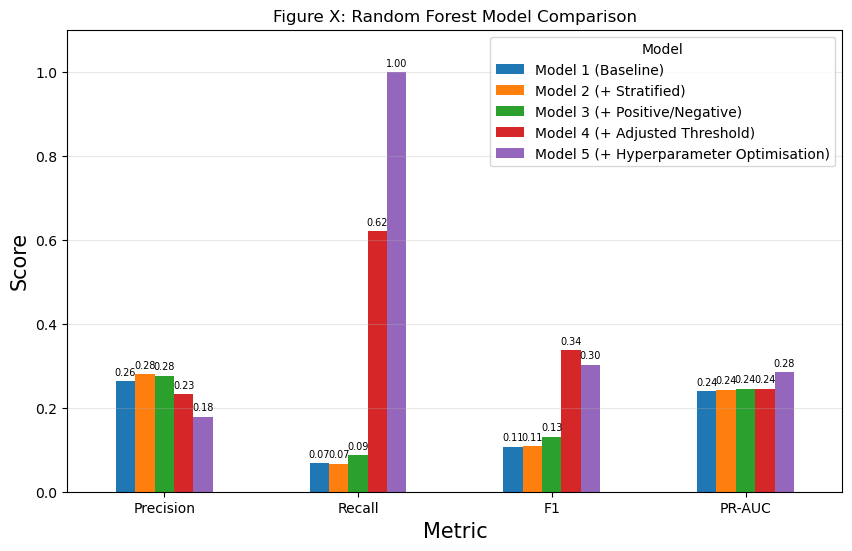

In [32]:
#Plot metrics
random_forest_scores = pd.DataFrame({
    'Model 1 (Baseline)': rf_metrics1,
    'Model 2 (+ Stratified)': rf_metrics2,
    'Model 3 (+ Positive/Negative)': rf_metrics3,
    'Model 4 (+ Adjusted Threshold)': rf_metrics4,
    'Model 5 (+ Hyperparameter Optimisation)': rf_metrics5})

ax = random_forest_scores.plot(kind = 'bar', figsize = (10, 6))

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f', padding = 3, fontsize = 7)

plt.title('Figure X: Random Forest Model Comparison')
plt.ylabel('Score', fontsize = 15)
plt.xlabel('Metric', fontsize = 15)
plt.ylim(0, 1.1)
plt.xticks(rotation = 0)
plt.legend(title = 'Model')
plt.grid(axis = 'y', alpha = 0.3)
plt.show()

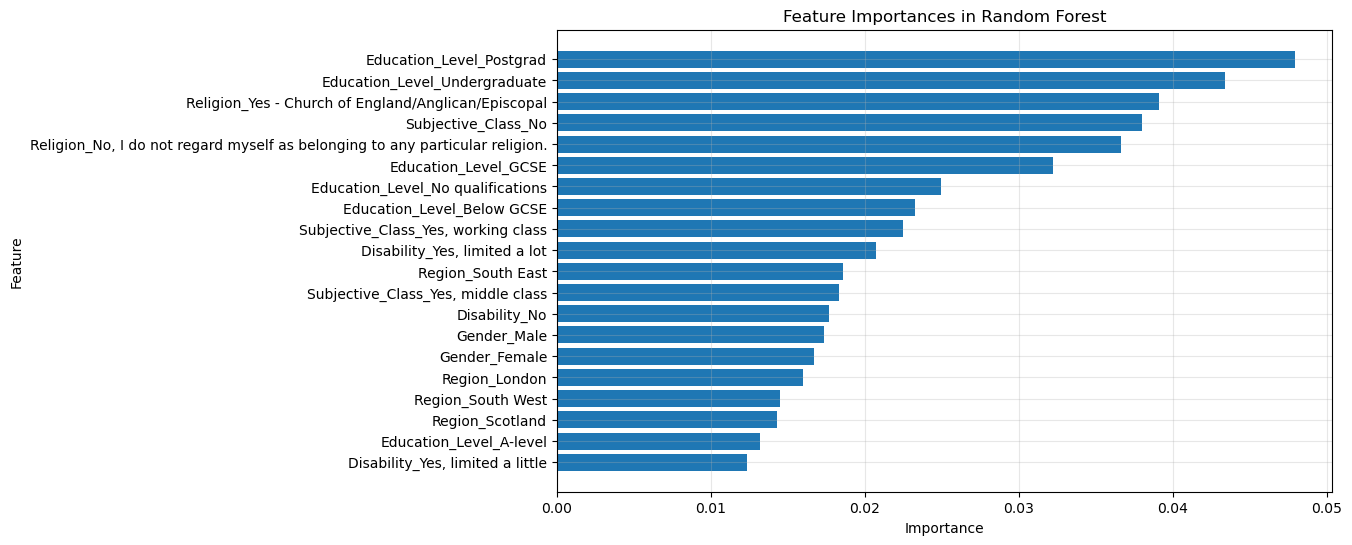

In [33]:
#Feature importance for model 5
importances = rf5.feature_importances_

sorted_idx = np.argsort(importances)[::-1]
top_idx = sorted_idx[:20]
sorted_features = [features[i] for i in top_idx]
sorted_importances = importances[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest')
plt.grid(alpha = 0.3)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
#K-Fold Cross Validation

Comparison

In [ ]:
#Comparison Table

In [ ]:
#Precision-Recall Curves

In [ ]:
#Confusion Matrix

In [ ]:
#Statistical Test?

In [34]:
print("Hello World")

Hello World


I have British Election study wave data loaded in a pandas dataframe called BES.
The target variable is 'Labour_vote' (0 or 1) and all the other columns are binary features (0/1). 
I have already split the data into training (80%) and testing (20%), and stratified this to overcome class imbalance, the training and test datasets are called BES_training_stratified and BES_testing_stratified, respectively.

Please help me:
1. Set up a hyperopt search space for XGBclassifier hyperparamters (max_depth, learning_rate, n_estimators, subsample, colsample_bytree, min_child_weight, and gamma).
2. Define a objective function that minimises negative F1 score.
3. Run Bayesian optimisation with 50 evaluations.
4. Add comments explaining each step.

Provide the code so I can copy and paste it into my notebook. 

Chat History